In [ ]:
!pip install pmdarima
!pip install statsmodels
import pandas as pd
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt
from google.colab import drive
from pmdarima.arima.utils import ndiffs
from numpy import mean
drive.mount('/content/drive')

     |████████████████████████████████| 1.4 MB 17.2 MB/s 
     |████████████████████████████████| 9.8 MB 48.9 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
Mounted at /content/drive


# preprocessing: lettura dei dati e splitting

In [ ]:
def read():
    go = False
    while (go == False):
        try:
            #separatore = input("INSERIRE SEPARATORE DEL FILE CSV: ")
            separatore = ";"

            df = pd.read_csv("/content/drive/MyDrive/tesi/latency.csv", sep=separatore, names=('Data', 'Latency'), header=1)
            go = True
        except ValueError:
            print("SEPARATORE NON RICONOSCIUTO")

    print("FILE IN INPUT LETTO CORRETTAMENTE")
    print(df)
    return df


def preprocessing(df):
    # converting timestamp into datetime
    df['Data'] = pd.to_datetime(df['Data'], unit='s')
    df = df.set_index('Data')

    df.plot(title="INPUT DATA: Distribuzione latenza dataset completo ")
    plt.savefig('/content/drive/MyDrive/tesi/Output/Graph/input_data_processed.pdf', bbox_inches='tight')
    plt.show()

    # splitting the initial dataframe in daily sub-dataframes
    DFDays = split_daily(df)
    DFHours = split_hour(DFDays)
    print("PREPROCESSING COMPLETATO")

    return df, DFDays, DFHours


def split_daily(df):
    # splitting main dataframe into daily sub-dataframes
    DFDays = [group[1] for group in df.groupby(df.index.day)]
    print(DFDays)
    return DFDays


def split_hour(DFDays):
    DFHours = pd.DataFrame()
    for i in range(len(DFDays)):
        DFHours[i] = [group[1] for group in DFDays[i].groupby(pd.Grouper(freq='6H'))]
    return DFHours

# Funzioni

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAXResultsWrapper

def modello_iterativo_hour(DFHours, DFDays):
    models=[SARIMAXResultsWrapper]*4 #vettore delle previsioni per ogni fascia
    for t in range(4):  # t= fascia oraria [0-5][6-11][12-17][18-23]
        i = 0  # indice sub-dataframe DFHours di training
        j = 1  # indice sub-dataframe DFHours di test usato per confronto con la previsione
        k = 0  # numero di iterazioni
        p = 0  # giorno
 #       models = []*4 #vettore dei modelli finali delle fasce
        while j < len(DFDays) - 1:
            if k == 0:  # se è la prima iterazione
                DFDI = unione_i_h(DFHours, i, t)
                model = sarima_auto(DFDI)
                result = predict_automatic_s(model, DFHours, i, j, t, k)
                k = k + 1

            # utilizzo l'indicatore MAPE per capire se il modello addestrato è ottimale (mape<5% excellent, mape<15% good, mape<20% accettapble)
            if result < 2.3:
                print("MODELLO N°:{} F:{} sufficientemente accurato".format(k, t))
                j = j + 1
                result = predict_automatic_s(model, DFHours, i, j, t, k)
                k = k + 1
            elif result > 2.3:
                print("MODELLO N°:{} F:{} non sufficientemente accurato".format(k, t))
                i = i + 1
                j = j + 1
                DFDI = unione_i_h(DFHours, i, t)
                model = sarima_auto(DFDI)
                result = predict_automatic_s(model, DFHours, i, j, t, k)
                k = k + 1

            if j >= len(DFDays)-1:
                if(t==0):
                    models[0]=model
                elif (t==1):
                    models[1]=model
                elif (t==2):
                    models[2]=model
                elif (t==3):
                    models[3]=model


        print("ADDESTRAMENTO FASCIA {} TERMINATO".format(t))
    return models

In [ ]:
def unione_i_h(DFHours, i, t):
    if i == 0:
        index_of_DFDI = np.arange(len(DFHours[0][t]))
        DFDI = pd.Series(DFHours[0][t].Latency.array, index=index_of_DFDI)
    elif i > 0:
        # estrazione valori
        v_support = pd.concat([DFHours[l][t] for l in range(0, i + 1)])
        # creazione indice numerico
        n_support = 0
        for p in range(0, i + 1):
            n_support = n_support + len(DFHours[p][t])
        index_of_DFDI = np.arange(n_support)
        # creazione serie
        DFDI = pd.Series(v_support.Latency.array, index_of_DFDI)
    return DFDI

def unione_j_h(DFHours, i, j, t,DFDI):
    # estrazione valori
    v_support = pd.concat([DFHours[l][t] for l in range(i + 1, j + 1)])
    # creazione indice numerico
    n_support = 0
    for p in range(i + 1, j + 1):
        n_support = n_support + len(DFHours[p][t])
    index_of_DFDJ = np.arange(len(DFDI),len(DFDI)+n_support)
    # creazione serie
    DFDJ = pd.Series(v_support.Latency.array, index_of_DFDJ)
    return DFDJ

In [ ]:
from pandas import Series
def prev_next_day_s(df,DFDays,DFHours,models):

    n_periods = 360  # numero campioni in una fascia di 6H (1 campione/min)
    forecast=[Series]*4 #vettore delle previsioni per ogni fascia
    lbound=[Series]*4 #vettore dei lower bound
    ubound=[Series]*4 #vettore degli upper bound

    for t in range(4): #per ogni fascia oraria
        fc, confint = models[t].predict(n_periods=n_periods, return_conf_int=True)
        index_of_fc = np.arange(len(df.Latency), len(df.Latency) + n_periods)
        # make series for plotting purpose
        forecast[t] = pd.Series(fc, index=index_of_fc)
        lbound[t] = pd.Series(confint[:, 0], index=index_of_fc)
        ubound[t] = pd.Series(confint[:, 1], index=index_of_fc)

        #plot forecasting
        # Plot
        plt.figure(figsize=(9, 3), dpi=100)
        plt.plot(forecast[t], color='darkgreen', label="FORECAST")
        plt.fill_between(lbound[t].index,
                         lbound[t],
                         ubound[t],
                         color='k', alpha=.15)
        plt.title('Latency predictions')
        plt.legend(loc='upper left', fontsize=8)
        PATH = "predizione_fascia_J.pdf"
        outPATH = PATH.replace("J", str(t))
        plt.savefig(outPATH, bbox_inches='tight')


    index_of_df = np.arange(len(df.Latency))
    df_series= pd.Series(df.Latency.array, index=index_of_df)


    #unione dei risultati di previsione
    fforecast = pd.concat([forecast[0],forecast[1],forecast[2],forecast[3]])
    flbound= pd.concat([lbound[0],lbound[1],lbound[2],lbound[3]])
    fubound= pd.concat([ubound[0],ubound[1],ubound[2],ubound[3]])

    # Plot
    plt.figure(figsize=(9, 3), dpi=100)
    plt.plot(df_series, label="DATASET INIZIALE")
    plt.plot(fforecast, color='darkgreen', label="FORECAST")
    plt.fill_between(flbound.index,
                     flbound,
                     fubound,
                     color='k', alpha=.15)

    plt.title('Latency predictions')
    plt.legend(loc='upper left', fontsize=8)
    outPATH = "predizione_sul_giorno_successivo_totale.pdf"
    plt.savefig(outPATH, bbox_inches='tight')

    plt.xlim(left=(len(df_series) - len(fforecast)))
    outPATH = "/content/drive/MyDrive/tesi/Output/Graph/predizione_sul_giorno_successivo_zoomed.pdf"
    plt.savefig(outPATH, bbox_inches='tight')

    plt.show()

    print("La media della latenza predetta per la prossima fascia oraria [0-5] è di: "+str(mean(forecast[0])))
    print("La media della latenza predetta per la prossima fascia oraria [6-11] è di: "+str(mean(forecast[1])))
    print("La media della latenza predetta per la prossima fascia oraria [12-17] è di: "+str(mean(forecast[2])))
    print("La media della latenza predetta per la prossima fascia oraria [18-23] è di: "+str(mean(forecast[3])))

    print("La media della latenza predetta per le 24 ore successive al {} è di: ".format(df.index[len(df) - 1]) + str(
    mean(fforecast)))

    with open("modello_finale_F0.txt", "w") as o:
        print(models[0].summary(), file=o)
        o.close()
    with open("modello_finale_F1.txt", "w") as o:
        print(models[1].summary(), file=o)
        o.close()
    with open("modello_finale_F2.txt", "w") as o:
        print(models[2].summary(), file=o)
        o.close()
    with open("modello_finale_F3.txt", "w") as o:
        print(models[3].summary(), file=o)
        o.close()

In [ ]:
def predict_automatic_s(model, DFHours, i, j, t, k):
    # Forecast
    n_periods = 0
    for p in range(i + 1, j + 1):
        n_periods = n_periods + len(DFHours[p][t])

    fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)

    DFDI = unione_i_h(DFHours, i, t)
    DFDJ = unione_j_h(DFHours, i, j, t,DFDI)

    # make series for plotting purpose
    fc_series = pd.Series(fc, index=DFDJ.index)
    lower_series = pd.Series(confint[:, 0], index=DFDJ.index)
    upper_series = pd.Series(confint[:, 1], index=DFDJ.index)

    # Plot
    plt.figure(figsize=(10, 3), dpi=100)
    plt.plot(DFDI, label="TRAINING SET")
    plt.plot(DFDJ, label="TEST SET")

    plt.plot(fc_series, color='darkgreen', label="FORECAST")
    plt.fill_between(lower_series.index,
                     lower_series,
                     upper_series,
                     color='k', alpha=.15)

    plt.title('Latency predictions')
    plt.legend(loc='upper left', fontsize=8)

    PATH = "Fascia_T_Giorno_J_arima_auto_predizione.pdf"
    outPATHt = PATH.replace("J", str(k))
    outPATH = outPATHt.replace("T", str(t))
    plt.savefig(outPATH, bbox_inches='tight')
    plt.show()

    print("La media della latenza predetta nel frame è: " + str(mean(fc_series)))
    print("La media della latenza effettiva nel frame è: " + str(mean(DFDJ.array)))
    result = np.mean(np.abs((DFDJ.array - fc) / DFDJ.array)) * 100
    print("MAPE: {}%".format(result))
    return result

In [ ]:
def sarima_auto(Frame):
    model = pm.auto_arima(Frame.array,
                          m=2,
                          D=1,
                          seasonal=True,
                          trace=True,
                          test="adf",
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)
    return model


# MAIN

FILE IN INPUT LETTO CORRETTAMENTE
             Data  Latency
0      1464825684   405.82
1      1464825756   472.61
2      1464825827   415.85
3      1464825898   431.53
4      1464825970   410.70
...           ...      ...
15733  1465948503   433.81
15734  1465948575   417.39
15735  1465948646   415.11
15736  1465948717   426.82
15737  1465948788   431.82

[15738 rows x 2 columns]


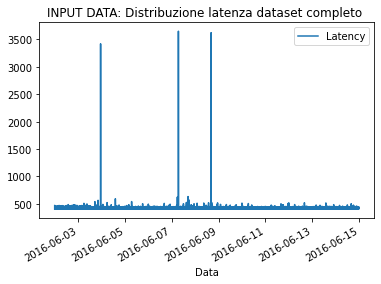

[                     Latency
Data                        
2016-06-02 00:01:24   405.82
2016-06-02 00:02:36   472.61
2016-06-02 00:03:47   415.85
2016-06-02 00:04:58   431.53
2016-06-02 00:06:10   410.70
...                      ...
2016-06-02 23:54:07   446.57
2016-06-02 23:55:19   431.17
2016-06-02 23:56:30   415.99
2016-06-02 23:57:41   443.85
2016-06-02 23:58:53   441.30

[1209 rows x 1 columns],                      Latency
Data                        
2016-06-03 00:00:04   419.80
2016-06-03 00:01:16   421.59
2016-06-03 00:02:27   445.41
2016-06-03 00:03:39   442.39
2016-06-03 00:04:50   411.22
...                      ...
2016-06-03 23:54:28   418.50
2016-06-03 23:55:39   409.61
2016-06-03 23:56:51   410.86
2016-06-03 23:58:02   413.85
2016-06-03 23:59:14   408.44

[1210 rows x 1 columns],                      Latency
Data                        
2016-06-04 00:00:25   412.92
2016-06-04 00:01:36   409.62
2016-06-04 00:02:48   435.92
2016-06-04 00:03:59   423.06
2016-06-04 00:05:11

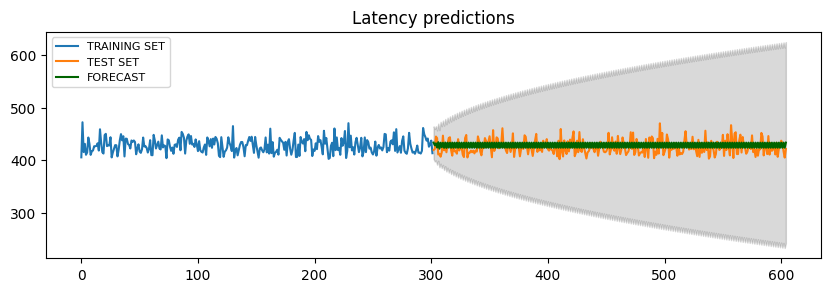

La media della latenza predetta nel frame è: 428.98326748321836
La media della latenza effettiva nel frame è: 425.5188118811884
MAPE: 2.928781267245032%
MODELLO N°:1 F:0 non sufficientemente accurato
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[2] intercept   : AIC=inf, Time=4.47 sec
 ARIMA(0,0,0)(0,1,0)[2] intercept   : AIC=5309.585, Time=0.07 sec
 ARIMA(1,0,0)(1,1,0)[2] intercept   : AIC=5132.220, Time=0.98 sec
 ARIMA(0,0,1)(0,1,1)[2] intercept   : AIC=inf, Time=1.86 sec
 ARIMA(0,0,0)(0,1,0)[2]             : AIC=5307.596, Time=0.05 sec
 ARIMA(1,0,0)(0,1,0)[2] intercept   : AIC=5311.581, Time=0.13 sec
 ARIMA(1,0,0)(2,1,0)[2] intercept   : AIC=5053.106, Time=0.62 sec
 ARIMA(1,0,0)(2,1,1)[2] intercept   : AIC=inf, Time=4.08 sec
 ARIMA(1,0,0)(1,1,1)[2] intercept   : AIC=inf, Time=2.72 sec
 ARIMA(0,0,0)(2,1,0)[2] intercept   : AIC=5052.257, Time=0.89 sec
 ARIMA(0,0,0)(1,1,0)[2] intercept   : AIC=5130.539, Time=0.19 sec
 ARIMA(0,0,0)(2,1,1)[2] intercept   : AIC=inf, Time

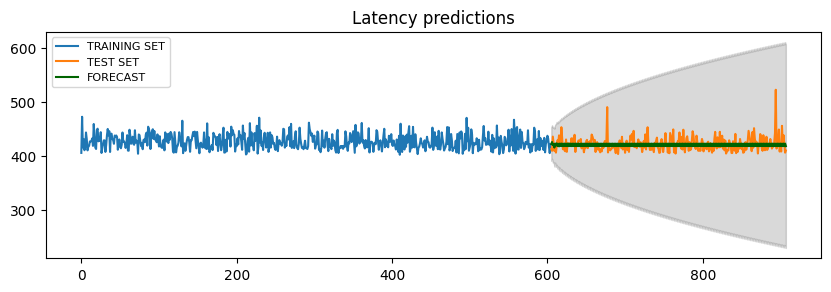

La media della latenza predetta nel frame è: 420.6769680999211
La media della latenza effettiva nel frame è: 421.9804290429043
MAPE: 2.1657717675600283%
MODELLO N°:2 F:0 sufficientemente accurato


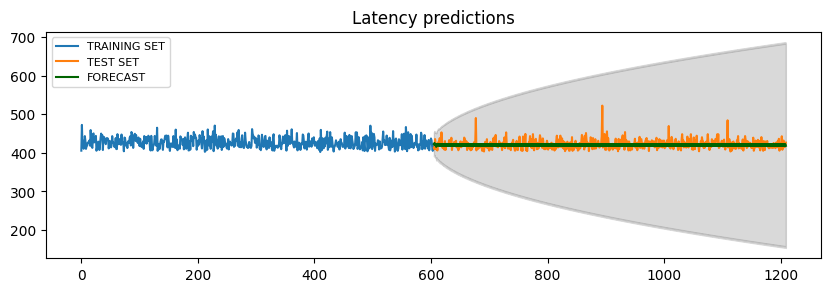

La media della latenza predetta nel frame è: 420.6712401997604
La media della latenza effettiva nel frame è: 422.58723966942136
MAPE: 2.1119166339434567%
MODELLO N°:3 F:0 sufficientemente accurato


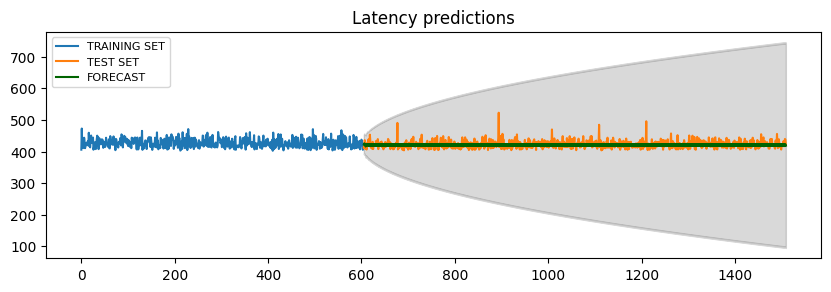

La media della latenza predetta nel frame è: 420.6693351610695
La media della latenza effettiva nel frame è: 422.888022099447
MAPE: 2.0915765186055775%
MODELLO N°:4 F:0 sufficientemente accurato


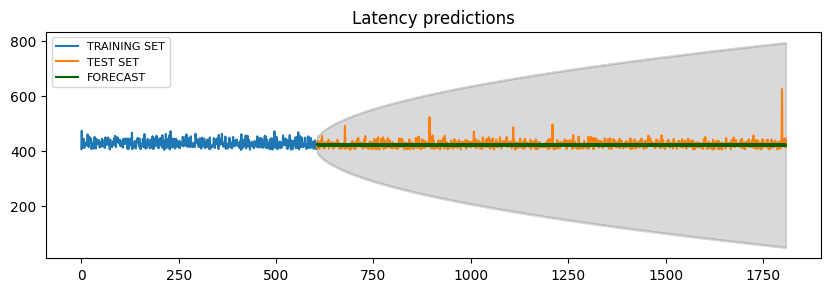

La media della latenza predetta nel frame è: 420.6683786893616
La media della latenza effettiva nel frame è: 422.9372033195018
MAPE: 2.103775205442519%
MODELLO N°:5 F:0 sufficientemente accurato


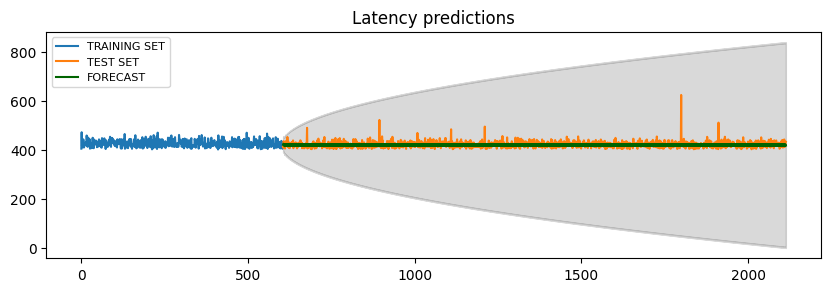

La media della latenza predetta nel frame è: 420.66779741148673
La media della latenza effettiva nel frame è: 422.7427302849566
MAPE: 2.1016790483324623%
MODELLO N°:6 F:0 sufficientemente accurato


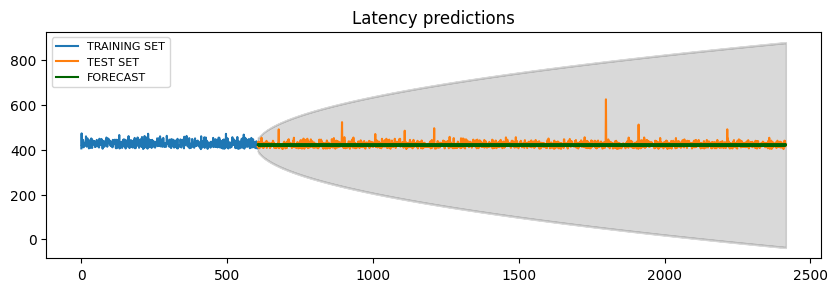

La media della latenza predetta nel frame è: 420.66869498544867
La media della latenza effettiva nel frame è: 422.59869205297946
MAPE: 2.090126636286557%
MODELLO N°:7 F:0 sufficientemente accurato


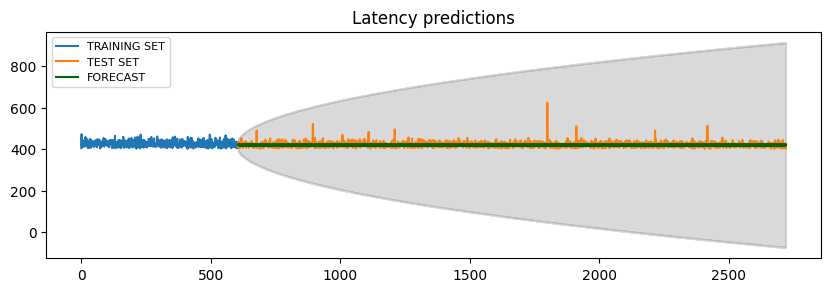

La media della latenza predetta nel frame è: 420.6682350127064
La media della latenza effettiva nel frame è: 422.2775897920596
MAPE: 2.0569070596060173%
MODELLO N°:8 F:0 sufficientemente accurato


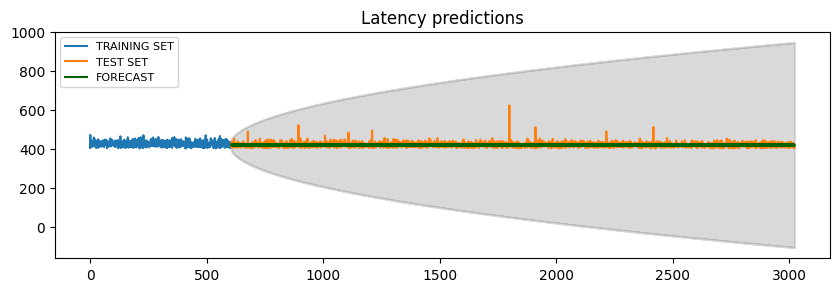

La media della latenza predetta nel frame è: 420.6669306436664
La media della latenza effettiva nel frame è: 422.12449772633244
MAPE: 2.0595536564105643%
MODELLO N°:9 F:0 sufficientemente accurato


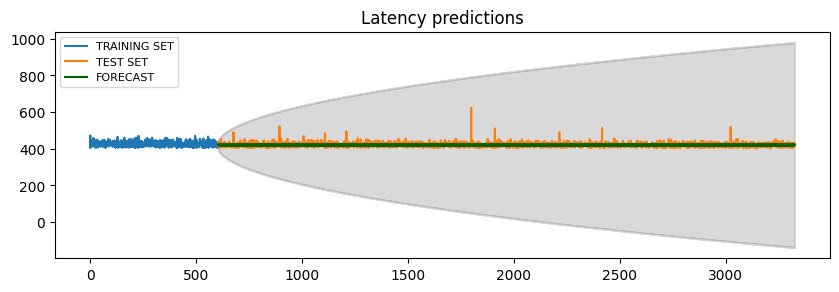

La media della latenza predetta nel frame è: 420.66762463142607
La media della latenza effettiva nel frame è: 421.98990815576695
MAPE: 2.063026938236381%
MODELLO N°:10 F:0 sufficientemente accurato


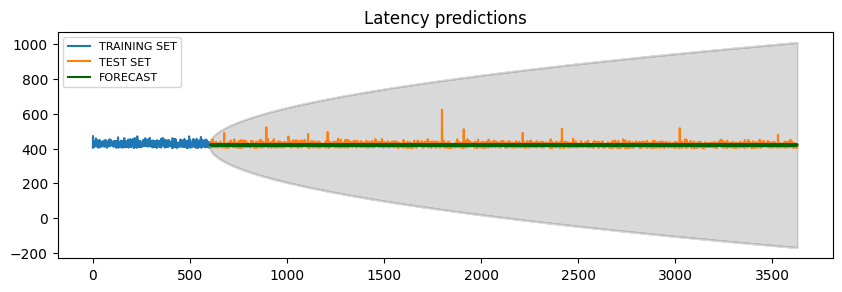

La media della latenza predetta nel frame è: 420.66741051553646
La media della latenza effettiva nel frame è: 421.8957633840049
MAPE: 2.0602133855825806%
MODELLO N°:11 F:0 sufficientemente accurato


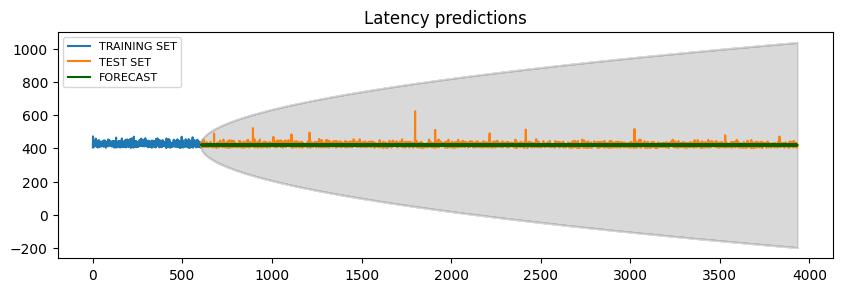

La media della latenza predetta nel frame è: 420.6665377471232
La media della latenza effettiva nel frame è: 421.78565635325833
MAPE: 2.0501155632977808%
ADDESTRAMENTO FASCIA 0 TERMINATO
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[2] intercept   : AIC=inf, Time=0.78 sec
 ARIMA(0,0,0)(0,1,0)[2] intercept   : AIC=2675.235, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[2] intercept   : AIC=2590.947, Time=0.15 sec
 ARIMA(0,0,1)(0,1,1)[2] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(0,0,0)(0,1,0)[2]             : AIC=2673.236, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[2] intercept   : AIC=2677.224, Time=0.07 sec
 ARIMA(1,0,0)(2,1,0)[2] intercept   : AIC=2548.388, Time=0.31 sec
 ARIMA(1,0,0)(2,1,1)[2] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(1,0,0)(1,1,1)[2] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(0,0,0)(2,1,0)[2] intercept   : AIC=2546.592, Time=0.15 sec
 ARIMA(0,0,0)(1,1,0)[2] intercept   : AIC=2589.036, Time=0.09 sec
 ARIMA(0,0,0)(2,1,1)[2] intercept   : AIC=inf, Time=0.84 sec
 AR

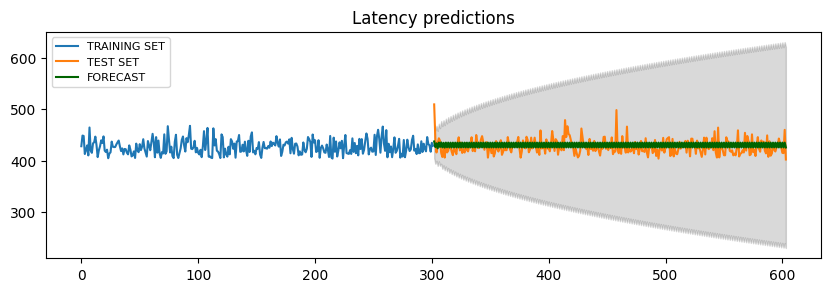

La media della latenza predetta nel frame è: 430.69360557452336
La media della latenza effettiva nel frame è: 427.610993377483
MAPE: 2.910709516560229%
MODELLO N°:1 F:1 non sufficientemente accurato
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[2] intercept   : AIC=inf, Time=1.48 sec
 ARIMA(0,0,0)(0,1,0)[2] intercept   : AIC=5359.120, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[2] intercept   : AIC=5182.279, Time=0.23 sec
 ARIMA(0,0,1)(0,1,1)[2] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(0,0,0)(0,1,0)[2]             : AIC=5357.120, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[2] intercept   : AIC=5361.022, Time=0.10 sec
 ARIMA(1,0,0)(2,1,0)[2] intercept   : AIC=5123.763, Time=0.36 sec
 ARIMA(1,0,0)(2,1,1)[2] intercept   : AIC=inf, Time=1.87 sec
 ARIMA(1,0,0)(1,1,1)[2] intercept   : AIC=inf, Time=1.10 sec
 ARIMA(0,0,0)(2,1,0)[2] intercept   : AIC=5122.371, Time=0.29 sec
 ARIMA(0,0,0)(1,1,0)[2] intercept   : AIC=5180.997, Time=0.13 sec
 ARIMA(0,0,0)(2,1,1)[2] intercept   : AIC=inf, Time=

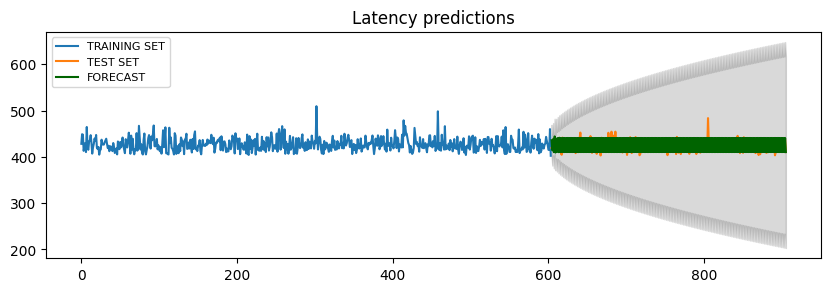

La media della latenza predetta nel frame è: 425.7594049833287
La media della latenza effettiva nel frame è: 423.01953642384103
MAPE: 3.833217217962242%
MODELLO N°:2 F:1 non sufficientemente accurato
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[2] intercept   : AIC=inf, Time=0.73 sec
 ARIMA(0,0,0)(0,1,0)[2] intercept   : AIC=7899.128, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[2] intercept   : AIC=7613.217, Time=0.35 sec
 ARIMA(0,0,1)(0,1,1)[2] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(0,0,0)(0,1,0)[2]             : AIC=7897.130, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[2] intercept   : AIC=7900.954, Time=0.10 sec
 ARIMA(1,0,0)(2,1,0)[2] intercept   : AIC=7533.604, Time=0.78 sec
 ARIMA(1,0,0)(2,1,1)[2] intercept   : AIC=inf, Time=1.66 sec
 ARIMA(1,0,0)(1,1,1)[2] intercept   : AIC=inf, Time=0.99 sec
 ARIMA(0,0,0)(2,1,0)[2] intercept   : AIC=7532.442, Time=0.31 sec
 ARIMA(0,0,0)(1,1,0)[2] intercept   : AIC=7612.259, Time=0.19 sec
 ARIMA(0,0,0)(2,1,1)[2] intercept   : AIC=inf, Time

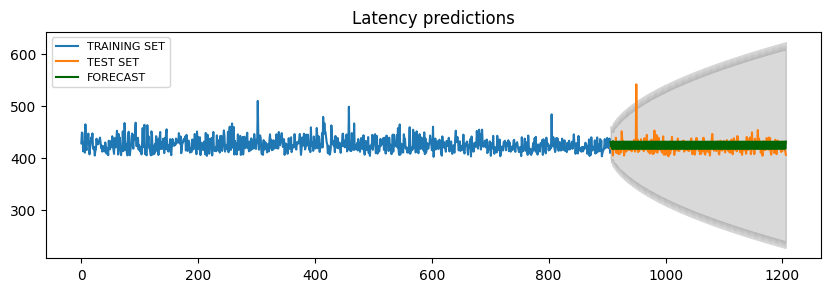

La media della latenza predetta nel frame è: 424.8588726681334
La media della latenza effettiva nel frame è: 422.08199335548164
MAPE: 2.4604230703096386%
MODELLO N°:3 F:1 non sufficientemente accurato
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[2] intercept   : AIC=inf, Time=2.06 sec
 ARIMA(0,0,0)(0,1,0)[2] intercept   : AIC=10466.663, Time=0.07 sec
 ARIMA(1,0,0)(1,1,0)[2] intercept   : AIC=10098.956, Time=0.45 sec
 ARIMA(0,0,1)(0,1,1)[2] intercept   : AIC=inf, Time=1.36 sec
 ARIMA(0,0,0)(0,1,0)[2]             : AIC=10464.671, Time=0.04 sec
 ARIMA(1,0,0)(0,1,0)[2] intercept   : AIC=10468.624, Time=0.13 sec
 ARIMA(1,0,0)(2,1,0)[2] intercept   : AIC=9980.168, Time=0.60 sec
 ARIMA(1,0,0)(2,1,1)[2] intercept   : AIC=inf, Time=3.16 sec
 ARIMA(1,0,0)(1,1,1)[2] intercept   : AIC=inf, Time=2.08 sec
 ARIMA(0,0,0)(2,1,0)[2] intercept   : AIC=9979.176, Time=0.39 sec
 ARIMA(0,0,0)(1,1,0)[2] intercept   : AIC=10097.820, Time=0.26 sec
 ARIMA(0,0,0)(2,1,1)[2] intercept   : AIC=inf

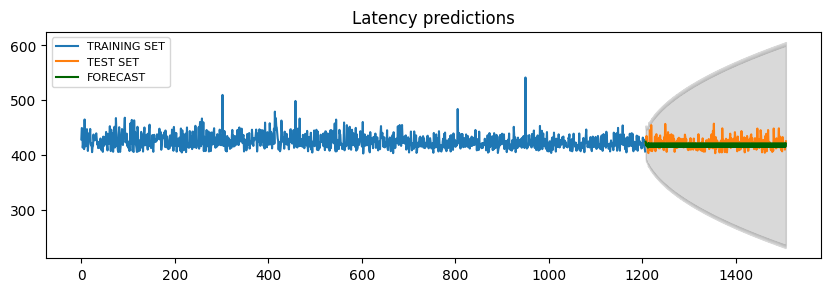

La media della latenza predetta nel frame è: 417.77128150504876
La media della latenza effettiva nel frame è: 420.8570099667775
MAPE: 2.0002027387151604%
MODELLO N°:4 F:1 sufficientemente accurato


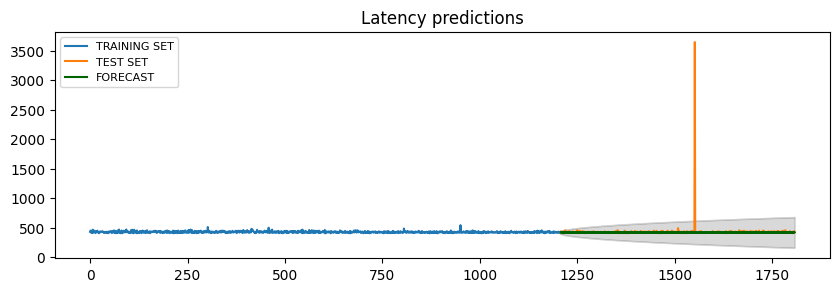

La media della latenza predetta nel frame è: 417.7569101650369
La media della latenza effettiva nel frame è: 426.7030282861897
MAPE: 2.164925843504357%
MODELLO N°:5 F:1 sufficientemente accurato


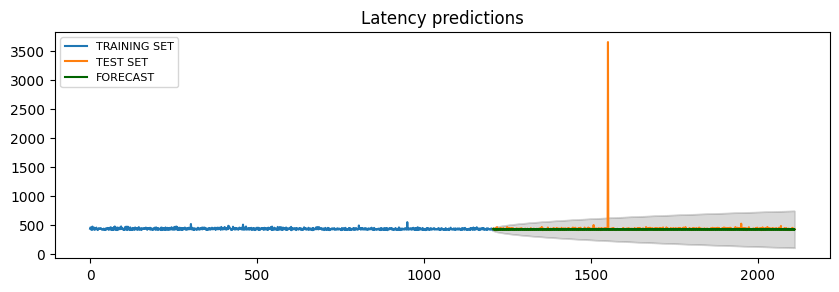

La media della latenza predetta nel frame è: 417.74864371193553
La media della latenza effettiva nel frame è: 425.41724557522184
MAPE: 2.249113922767005%
MODELLO N°:6 F:1 sufficientemente accurato


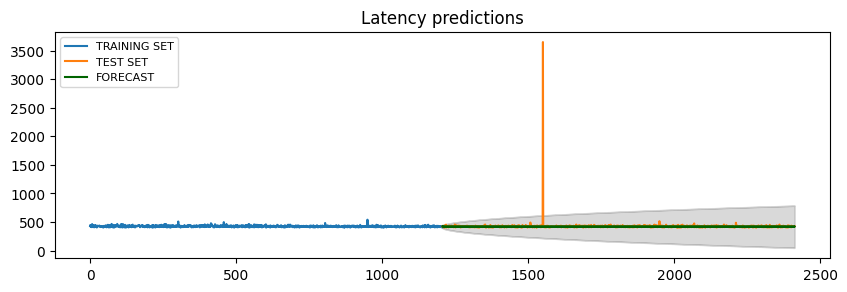

La media della latenza predetta nel frame è: 417.74967067692256
La media della latenza effettiva nel frame è: 424.31253521126814
MAPE: 2.211453429707429%
MODELLO N°:7 F:1 sufficientemente accurato


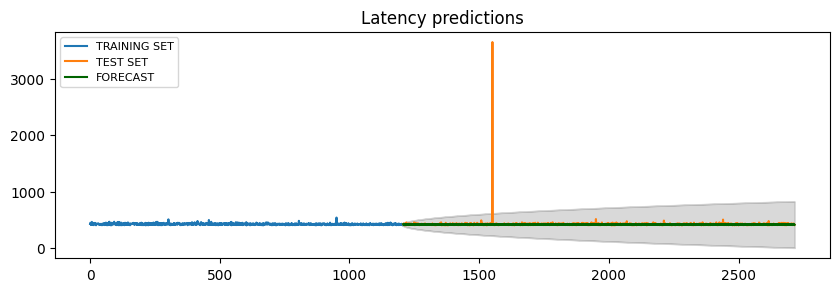

La media della latenza predetta nel frame è: 417.746174445997
La media della latenza effettiva nel frame è: 423.82466225165575
MAPE: 2.218049530785714%
MODELLO N°:8 F:1 sufficientemente accurato


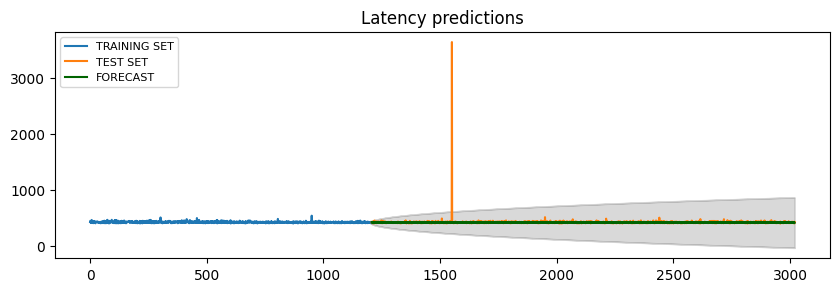

La media della latenza predetta nel frame è: 417.7455571407464
La media della latenza effettiva nel frame è: 423.51712789415654
MAPE: 2.194897563720379%
MODELLO N°:9 F:1 sufficientemente accurato


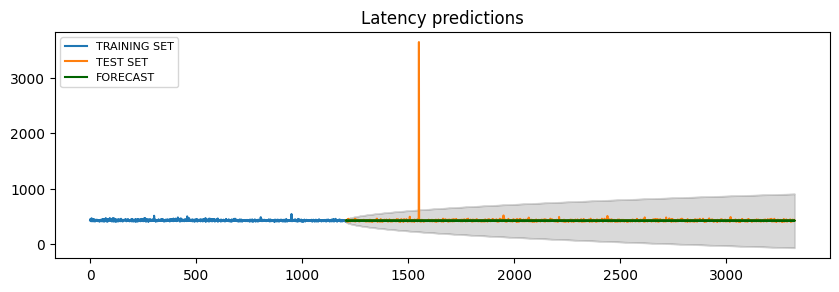

La media della latenza predetta nel frame è: 417.7465844330556
La media della latenza effettiva nel frame è: 423.2848417572037
MAPE: 2.1977869565257513%
MODELLO N°:10 F:1 sufficientemente accurato


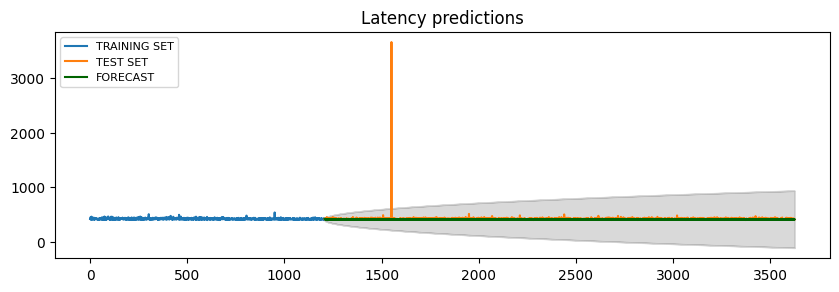

La media della latenza predetta nel frame è: 417.74478931867355
La media della latenza effettiva nel frame è: 423.145161157025
MAPE: 2.1896133510395916%
MODELLO N°:11 F:1 sufficientemente accurato


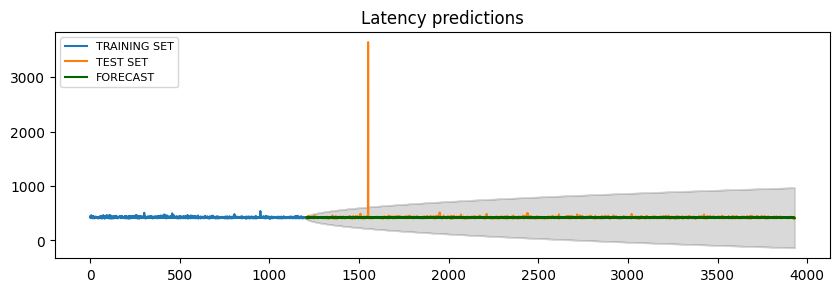

La media della latenza predetta nel frame è: 417.744532816088
La media della latenza effettiva nel frame è: 422.9656828193842
MAPE: 2.178075635089041%
ADDESTRAMENTO FASCIA 1 TERMINATO
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[2] intercept   : AIC=inf, Time=0.92 sec
 ARIMA(0,0,0)(0,1,0)[2] intercept   : AIC=2660.983, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[2] intercept   : AIC=2578.341, Time=0.24 sec
 ARIMA(0,0,1)(0,1,1)[2] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(0,0,0)(0,1,0)[2]             : AIC=2658.983, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[2] intercept   : AIC=2662.983, Time=0.05 sec
 ARIMA(1,0,0)(2,1,0)[2] intercept   : AIC=2544.271, Time=0.30 sec
 ARIMA(1,0,0)(2,1,1)[2] intercept   : AIC=inf, Time=0.89 sec
 ARIMA(1,0,0)(1,1,1)[2] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(0,0,0)(2,1,0)[2] intercept   : AIC=2542.878, Time=0.46 sec
 ARIMA(0,0,0)(1,1,0)[2] intercept   : AIC=2576.450, Time=0.14 sec
 ARIMA(0,0,0)(2,1,1)[2] intercept   : AIC=inf, Time=0.70 sec
 ARIMA

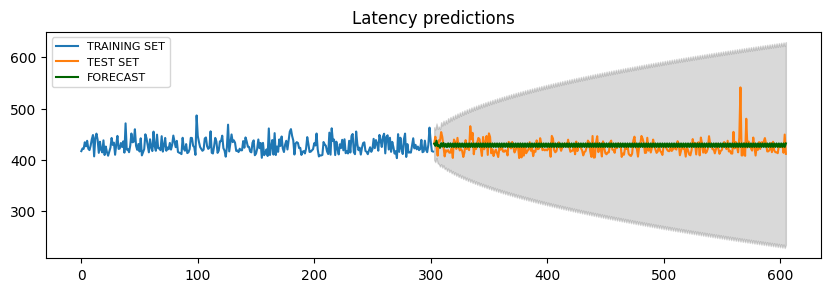

La media della latenza predetta nel frame è: 428.584971738598
La media della latenza effettiva nel frame è: 424.3472277227719
MAPE: 2.6052590359022725%
MODELLO N°:1 F:2 non sufficientemente accurato
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[2] intercept   : AIC=inf, Time=1.24 sec
 ARIMA(0,0,0)(0,1,0)[2] intercept   : AIC=5316.912, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[2] intercept   : AIC=5153.449, Time=0.26 sec
 ARIMA(0,0,1)(0,1,1)[2] intercept   : AIC=inf, Time=0.94 sec
 ARIMA(0,0,0)(0,1,0)[2]             : AIC=5314.914, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[2] intercept   : AIC=5318.672, Time=0.10 sec
 ARIMA(1,0,0)(2,1,0)[2] intercept   : AIC=5051.894, Time=0.36 sec
 ARIMA(1,0,0)(2,1,1)[2] intercept   : AIC=inf, Time=1.64 sec
 ARIMA(1,0,0)(1,1,1)[2] intercept   : AIC=inf, Time=1.21 sec
 ARIMA(0,0,0)(2,1,0)[2] intercept   : AIC=5050.289, Time=0.22 sec
 ARIMA(0,0,0)(1,1,0)[2] intercept   : AIC=5151.452, Time=0.11 sec
 ARIMA(0,0,0)(2,1,1)[2] intercept   : AIC=inf, Time=

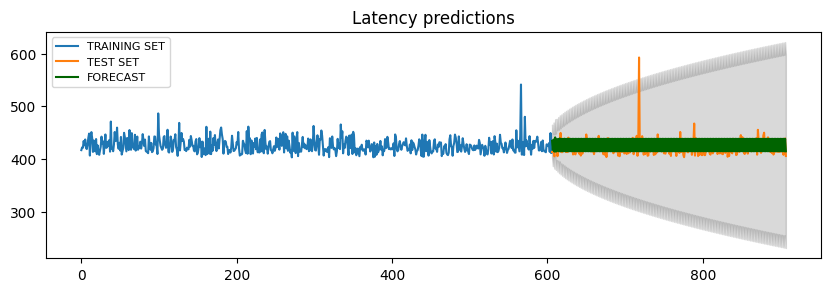

La media della latenza predetta nel frame è: 426.6501627366853
La media della latenza effettiva nel frame è: 421.88288079470203
MAPE: 3.2136190843582915%
MODELLO N°:2 F:2 non sufficientemente accurato
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[2] intercept   : AIC=inf, Time=2.91 sec
 ARIMA(0,0,0)(0,1,0)[2] intercept   : AIC=8007.418, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[2] intercept   : AIC=7739.194, Time=0.45 sec
 ARIMA(0,0,1)(0,1,1)[2] intercept   : AIC=inf, Time=1.42 sec
 ARIMA(0,0,0)(0,1,0)[2]             : AIC=8005.419, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[2] intercept   : AIC=8009.418, Time=0.10 sec
 ARIMA(1,0,0)(2,1,0)[2] intercept   : AIC=7620.262, Time=0.54 sec
 ARIMA(1,0,0)(2,1,1)[2] intercept   : AIC=inf, Time=2.27 sec
 ARIMA(1,0,0)(1,1,1)[2] intercept   : AIC=inf, Time=1.66 sec
 ARIMA(0,0,0)(2,1,0)[2] intercept   : AIC=7618.463, Time=0.49 sec
 ARIMA(0,0,0)(1,1,0)[2] intercept   : AIC=7737.285, Time=0.18 sec
 ARIMA(0,0,0)(2,1,1)[2] intercept   : AIC=inf, Tim

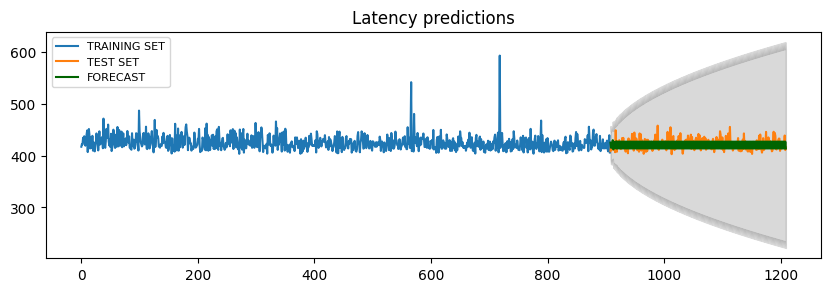

La media della latenza predetta nel frame è: 420.2588057317144
La media della latenza effettiva nel frame è: 421.9653311258278
MAPE: 2.346013552960639%
MODELLO N°:3 F:2 non sufficientemente accurato
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[2] intercept   : AIC=inf, Time=3.14 sec
 ARIMA(0,0,0)(0,1,0)[2] intercept   : AIC=10523.466, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[2] intercept   : AIC=10166.950, Time=0.47 sec
 ARIMA(0,0,1)(0,1,1)[2] intercept   : AIC=inf, Time=1.62 sec
 ARIMA(0,0,0)(0,1,0)[2]             : AIC=10521.467, Time=0.04 sec
 ARIMA(1,0,0)(0,1,0)[2] intercept   : AIC=10525.456, Time=0.11 sec
 ARIMA(1,0,0)(2,1,0)[2] intercept   : AIC=10016.295, Time=0.65 sec
 ARIMA(1,0,0)(2,1,1)[2] intercept   : AIC=inf, Time=2.65 sec
 ARIMA(1,0,0)(1,1,1)[2] intercept   : AIC=inf, Time=2.34 sec
 ARIMA(0,0,0)(2,1,0)[2] intercept   : AIC=10014.420, Time=0.38 sec
 ARIMA(0,0,0)(1,1,0)[2] intercept   : AIC=10164.987, Time=0.22 sec
 ARIMA(0,0,0)(2,1,1)[2] intercept   : AIC=inf

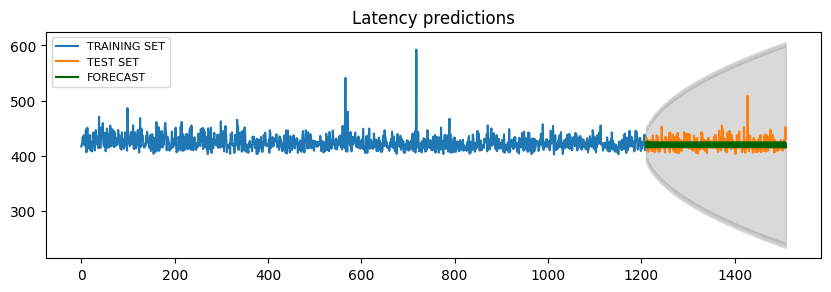

La media della latenza predetta nel frame è: 420.1170995760378
La media della latenza effettiva nel frame è: 422.0970099667772
MAPE: 2.207977042475566%
MODELLO N°:4 F:2 sufficientemente accurato


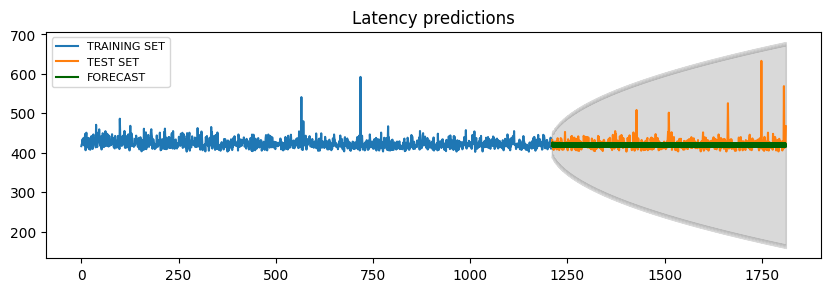

La media della latenza predetta nel frame è: 420.1178674557287
La media della latenza effettiva nel frame è: 422.7347263681594
MAPE: 2.320268633355872%
MODELLO N°:5 F:2 non sufficientemente accurato
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[2] intercept   : AIC=inf, Time=3.56 sec
 ARIMA(0,0,0)(0,1,0)[2] intercept   : AIC=13072.154, Time=0.06 sec
 ARIMA(1,0,0)(1,1,0)[2] intercept   : AIC=12625.952, Time=0.39 sec
 ARIMA(0,0,1)(0,1,1)[2] intercept   : AIC=inf, Time=1.04 sec
 ARIMA(0,0,0)(0,1,0)[2]             : AIC=13070.158, Time=0.05 sec
 ARIMA(1,0,0)(0,1,0)[2] intercept   : AIC=13074.040, Time=0.13 sec
 ARIMA(1,0,0)(2,1,0)[2] intercept   : AIC=12450.294, Time=0.67 sec
 ARIMA(1,0,0)(2,1,1)[2] intercept   : AIC=inf, Time=3.75 sec
 ARIMA(1,0,0)(1,1,1)[2] intercept   : AIC=inf, Time=2.43 sec
 ARIMA(0,0,0)(2,1,0)[2] intercept   : AIC=12448.335, Time=0.75 sec
 ARIMA(0,0,0)(1,1,0)[2] intercept   : AIC=12624.003, Time=0.33 sec
 ARIMA(0,0,0)(2,1,1)[2] intercept   : AIC=inf

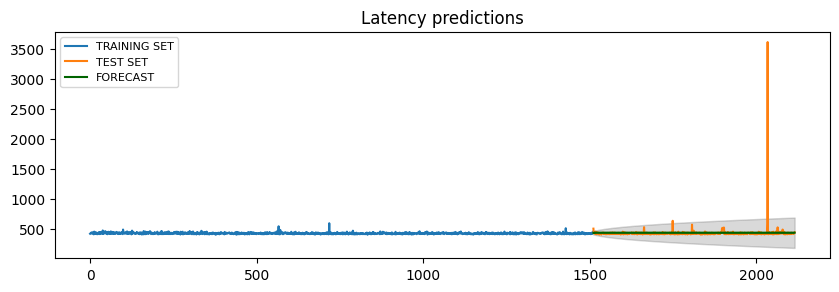

La media della latenza predetta nel frame è: 433.1716448143601
La media della latenza effettiva nel frame è: 429.65489256198333
MAPE: 3.6764645347902567%
MODELLO N°:6 F:2 non sufficientemente accurato
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[2] intercept   : AIC=inf, Time=1.26 sec
 ARIMA(0,0,0)(0,1,0)[2] intercept   : AIC=16061.183, Time=0.08 sec
 ARIMA(1,0,0)(1,1,0)[2] intercept   : AIC=15530.657, Time=0.76 sec
 ARIMA(0,0,1)(0,1,1)[2] intercept   : AIC=inf, Time=1.79 sec
 ARIMA(0,0,0)(0,1,0)[2]             : AIC=16059.186, Time=0.06 sec
 ARIMA(1,0,0)(0,1,0)[2] intercept   : AIC=16063.096, Time=0.14 sec
 ARIMA(1,0,0)(2,1,0)[2] intercept   : AIC=15297.562, Time=0.66 sec
 ARIMA(1,0,0)(2,1,1)[2] intercept   : AIC=inf, Time=2.70 sec
 ARIMA(1,0,0)(1,1,1)[2] intercept   : AIC=inf, Time=1.63 sec
 ARIMA(0,0,0)(2,1,0)[2] intercept   : AIC=15295.572, Time=0.61 sec
 ARIMA(0,0,0)(1,1,0)[2] intercept   : AIC=15528.665, Time=0.38 sec
 ARIMA(0,0,0)(2,1,1)[2] intercept   : AIC=i

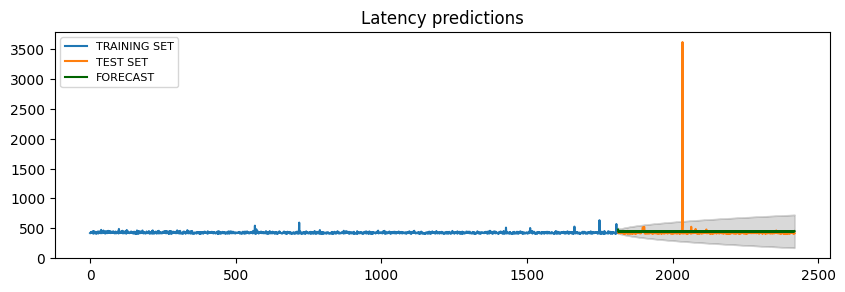

La media della latenza predetta nel frame è: 445.9856337275409
La media della latenza effettiva nel frame è: 429.1192257001646
MAPE: 6.016697739570902%
MODELLO N°:7 F:2 non sufficientemente accurato
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[2] intercept   : AIC=inf, Time=1.94 sec
 ARIMA(0,0,0)(0,1,0)[2] intercept   : AIC=25507.719, Time=0.09 sec
 ARIMA(1,0,0)(1,1,0)[2] intercept   : AIC=24898.223, Time=0.84 sec
 ARIMA(0,0,1)(0,1,1)[2] intercept   : AIC=inf, Time=2.13 sec
 ARIMA(0,0,0)(0,1,0)[2]             : AIC=25505.720, Time=0.06 sec
 ARIMA(1,0,0)(0,1,0)[2] intercept   : AIC=25508.382, Time=0.08 sec
 ARIMA(1,0,0)(2,1,0)[2] intercept   : AIC=24651.571, Time=1.28 sec
 ARIMA(1,0,0)(2,1,1)[2] intercept   : AIC=inf, Time=2.19 sec
 ARIMA(1,0,0)(1,1,1)[2] intercept   : AIC=inf, Time=1.57 sec
 ARIMA(0,0,0)(2,1,0)[2] intercept   : AIC=24653.425, Time=0.77 sec
 ARIMA(1,0,1)(2,1,0)[2] intercept   : AIC=inf, Time=5.23 sec
 ARIMA(0,0,1)(2,1,0)[2] intercept   : AIC=24650.821

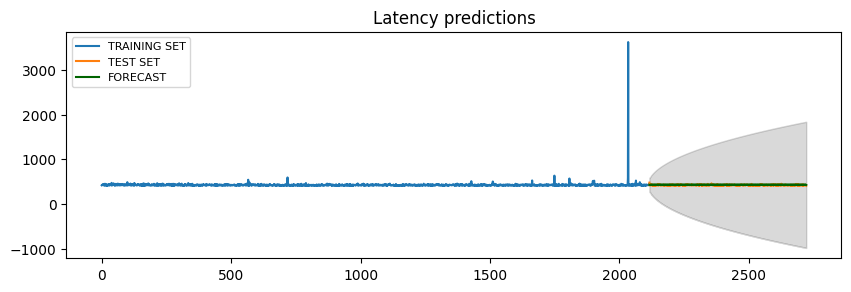

La media della latenza predetta nel frame è: 427.945493122611
La media della latenza effettiva nel frame è: 421.4388138385503
MAPE: 2.475379076294669%
MODELLO N°:8 F:2 non sufficientemente accurato
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[2] intercept   : AIC=inf, Time=2.21 sec
 ARIMA(0,0,0)(0,1,0)[2] intercept   : AIC=28857.947, Time=0.09 sec
 ARIMA(1,0,0)(1,1,0)[2] intercept   : AIC=28159.678, Time=1.00 sec
 ARIMA(0,0,1)(0,1,1)[2] intercept   : AIC=inf, Time=1.43 sec
 ARIMA(0,0,0)(0,1,0)[2]             : AIC=28855.948, Time=0.06 sec
 ARIMA(1,0,0)(0,1,0)[2] intercept   : AIC=28858.421, Time=0.09 sec
 ARIMA(1,0,0)(2,1,0)[2] intercept   : AIC=27877.615, Time=1.42 sec
 ARIMA(1,0,0)(2,1,1)[2] intercept   : AIC=inf, Time=2.57 sec
 ARIMA(1,0,0)(1,1,1)[2] intercept   : AIC=inf, Time=1.67 sec
 ARIMA(0,0,0)(2,1,0)[2] intercept   : AIC=27880.024, Time=0.84 sec
 ARIMA(1,0,1)(2,1,0)[2] intercept   : AIC=inf, Time=6.23 sec
 ARIMA(0,0,1)(2,1,0)[2] intercept   : AIC=27876.757,

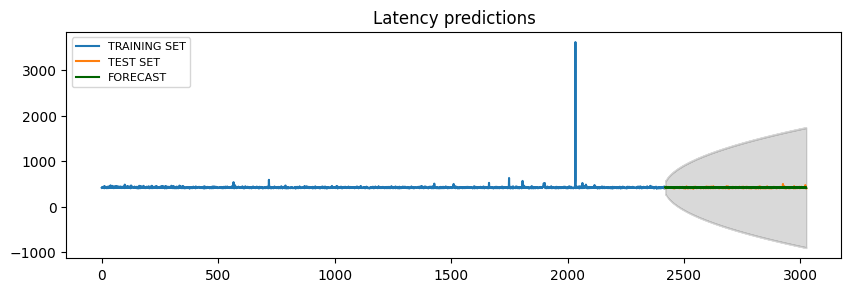

La media della latenza predetta nel frame è: 422.0653726743063
La media della latenza effettiva nel frame è: 420.68420792079235
MAPE: 2.694004152956484%
MODELLO N°:9 F:2 non sufficientemente accurato
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[2] intercept   : AIC=inf, Time=2.27 sec
 ARIMA(0,0,0)(0,1,0)[2] intercept   : AIC=32159.140, Time=0.10 sec
 ARIMA(1,0,0)(1,1,0)[2] intercept   : AIC=31373.466, Time=1.07 sec
 ARIMA(0,0,1)(0,1,1)[2] intercept   : AIC=inf, Time=1.75 sec
 ARIMA(0,0,0)(0,1,0)[2]             : AIC=32157.141, Time=0.06 sec
 ARIMA(1,0,0)(0,1,0)[2] intercept   : AIC=32159.445, Time=0.10 sec
 ARIMA(1,0,0)(2,1,0)[2] intercept   : AIC=31055.986, Time=1.65 sec
 ARIMA(1,0,0)(2,1,1)[2] intercept   : AIC=inf, Time=2.86 sec
 ARIMA(1,0,0)(1,1,1)[2] intercept   : AIC=inf, Time=3.02 sec
 ARIMA(0,0,0)(2,1,0)[2] intercept   : AIC=31058.885, Time=0.96 sec
 ARIMA(1,0,1)(2,1,0)[2] intercept   : AIC=inf, Time=7.16 sec
 ARIMA(0,0,1)(2,1,0)[2] intercept   : AIC=31055.03

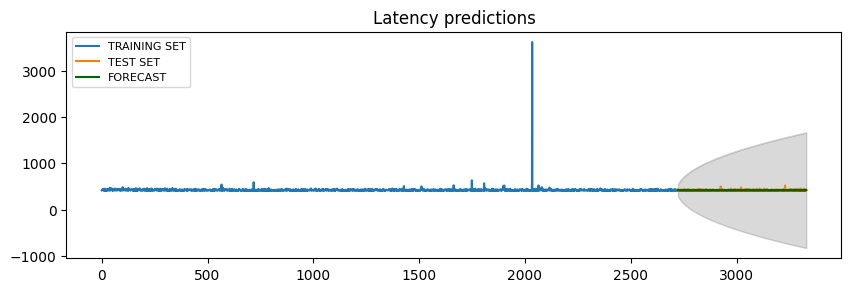

La media della latenza predetta nel frame è: 418.2720659280162
La media della latenza effettiva nel frame è: 421.64660626029666
MAPE: 2.1310704019224884%
MODELLO N°:10 F:2 sufficientemente accurato


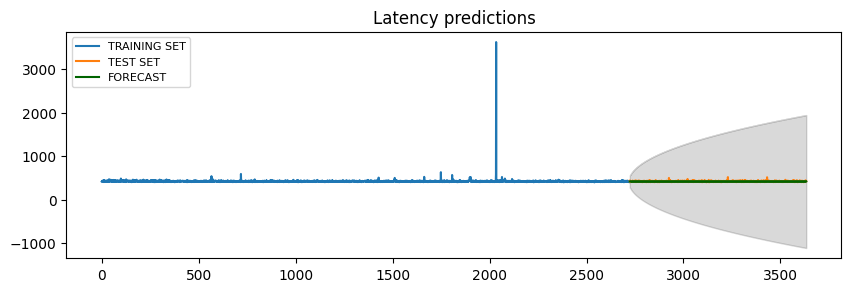

La media della latenza predetta nel frame è: 418.2690416566457
La media della latenza effettiva nel frame è: 421.55661909989016
MAPE: 2.1365938889856486%
MODELLO N°:11 F:2 sufficientemente accurato


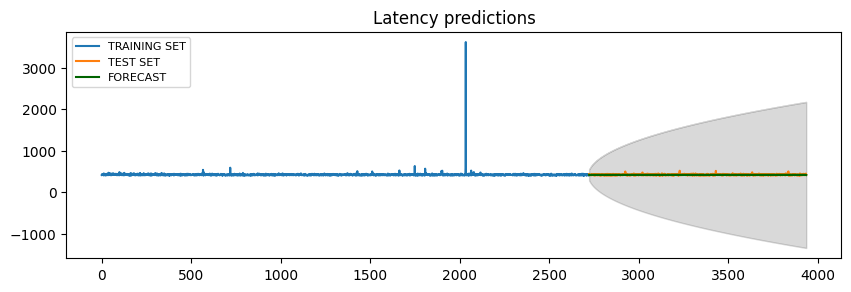

La media della latenza predetta nel frame è: 418.26651578004055
La media della latenza effettiva nel frame è: 421.6802141680397
MAPE: 2.1297852169400078%
ADDESTRAMENTO FASCIA 2 TERMINATO
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[2] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(0,0,0)(0,1,0)[2] intercept   : AIC=2698.493, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[2] intercept   : AIC=2619.583, Time=0.23 sec
 ARIMA(0,0,1)(0,1,1)[2] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(0,0,0)(0,1,0)[2]             : AIC=2696.495, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[2] intercept   : AIC=2700.488, Time=0.09 sec
 ARIMA(1,0,0)(2,1,0)[2] intercept   : AIC=2580.063, Time=0.30 sec
 ARIMA(1,0,0)(2,1,1)[2] intercept   : AIC=inf, Time=0.87 sec
 ARIMA(1,0,0)(1,1,1)[2] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(0,0,0)(2,1,0)[2] intercept   : AIC=2579.025, Time=0.24 sec
 ARIMA(0,0,0)(1,1,0)[2] intercept   : AIC=2617.873, Time=0.11 sec
 ARIMA(0,0,0)(2,1,1)[2] intercept   : AIC=inf, Time=0.67 sec
 AR

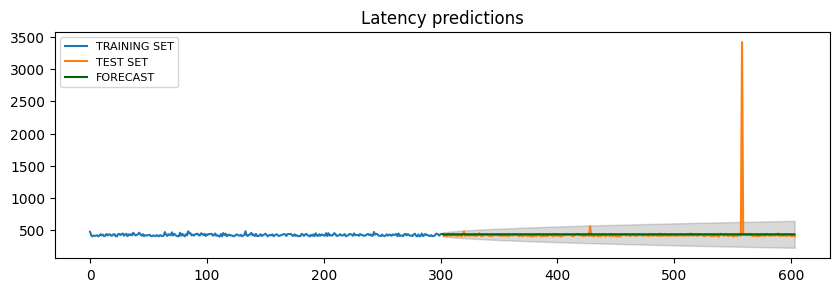

La media della latenza predetta nel frame è: 436.8239097358365
La media della latenza effettiva nel frame è: 432.0930794701987
MAPE: 4.360249096853165%
MODELLO N°:1 F:3 non sufficientemente accurato
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[2] intercept   : AIC=inf, Time=0.84 sec
 ARIMA(0,0,0)(0,1,0)[2] intercept   : AIC=7922.184, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[2] intercept   : AIC=7756.068, Time=0.33 sec
 ARIMA(0,0,1)(0,1,1)[2] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(0,0,0)(0,1,0)[2]             : AIC=7920.185, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[2] intercept   : AIC=7924.185, Time=0.07 sec
 ARIMA(1,0,0)(2,1,0)[2] intercept   : AIC=7686.629, Time=0.50 sec
 ARIMA(1,0,0)(2,1,1)[2] intercept   : AIC=inf, Time=0.92 sec
 ARIMA(1,0,0)(1,1,1)[2] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(0,0,0)(2,1,0)[2] intercept   : AIC=7684.632, Time=0.36 sec
 ARIMA(0,0,0)(1,1,0)[2] intercept   : AIC=7754.071, Time=0.20 sec
 ARIMA(0,0,0)(2,1,1)[2] intercept   : AIC=inf, Time=

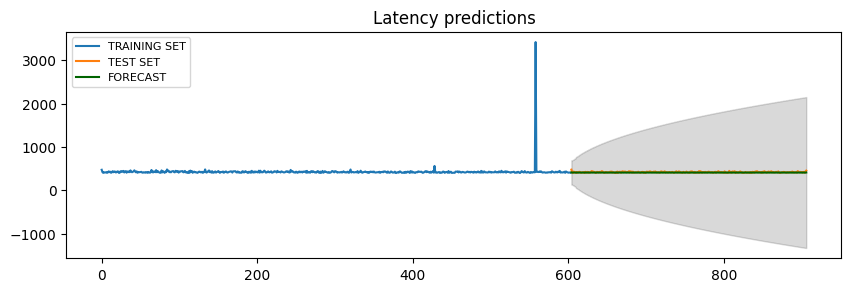

La media della latenza predetta nel frame è: 412.3727202623461
La media della latenza effettiva nel frame è: 422.22801980197994
MAPE: 2.591348939552967%
MODELLO N°:2 F:3 non sufficientemente accurato
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[2] intercept   : AIC=inf, Time=1.15 sec
 ARIMA(0,0,0)(0,1,0)[2] intercept   : AIC=11541.945, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[2] intercept   : AIC=11290.080, Time=0.44 sec
 ARIMA(0,0,1)(0,1,1)[2] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(0,0,0)(0,1,0)[2]             : AIC=11539.945, Time=0.04 sec
 ARIMA(1,0,0)(0,1,0)[2] intercept   : AIC=11543.945, Time=0.08 sec
 ARIMA(1,0,0)(2,1,0)[2] intercept   : AIC=11184.454, Time=0.67 sec
 ARIMA(1,0,0)(2,1,1)[2] intercept   : AIC=inf, Time=1.20 sec
 ARIMA(1,0,0)(1,1,1)[2] intercept   : AIC=inf, Time=0.85 sec
 ARIMA(0,0,0)(2,1,0)[2] intercept   : AIC=11182.458, Time=0.45 sec
 ARIMA(0,0,0)(1,1,0)[2] intercept   : AIC=11288.084, Time=0.29 sec
 ARIMA(0,0,0)(2,1,1)[2] intercept   : AIC=in

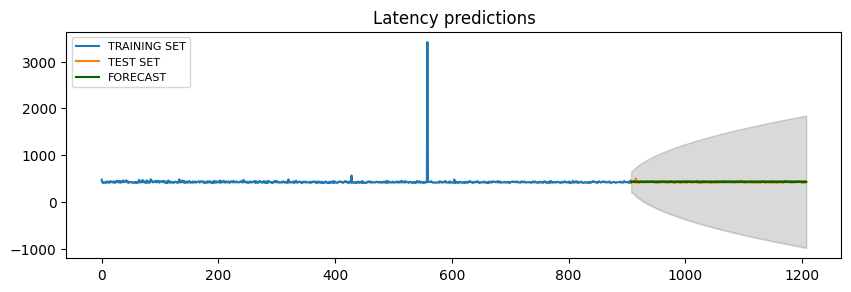

La media della latenza predetta nel frame è: 432.51090138886764
La media della latenza effettiva nel frame è: 422.0290033222594
MAPE: 3.173633965126257%
MODELLO N°:3 F:3 non sufficientemente accurato
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[2] intercept   : AIC=inf, Time=1.18 sec
 ARIMA(0,0,0)(0,1,0)[2] intercept   : AIC=15038.055, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[2] intercept   : AIC=14701.000, Time=0.48 sec
 ARIMA(0,0,1)(0,1,1)[2] intercept   : AIC=inf, Time=0.81 sec
 ARIMA(0,0,0)(0,1,0)[2]             : AIC=15036.055, Time=0.04 sec
 ARIMA(1,0,0)(0,1,0)[2] intercept   : AIC=15040.054, Time=0.09 sec
 ARIMA(1,0,0)(2,1,0)[2] intercept   : AIC=14559.605, Time=0.76 sec
 ARIMA(1,0,0)(2,1,1)[2] intercept   : AIC=inf, Time=1.44 sec
 ARIMA(1,0,0)(1,1,1)[2] intercept   : AIC=inf, Time=0.98 sec
 ARIMA(0,0,0)(2,1,0)[2] intercept   : AIC=14557.610, Time=0.56 sec
 ARIMA(0,0,0)(1,1,0)[2] intercept   : AIC=14699.005, Time=0.28 sec
 ARIMA(0,0,0)(2,1,1)[2] intercept   : AIC=in

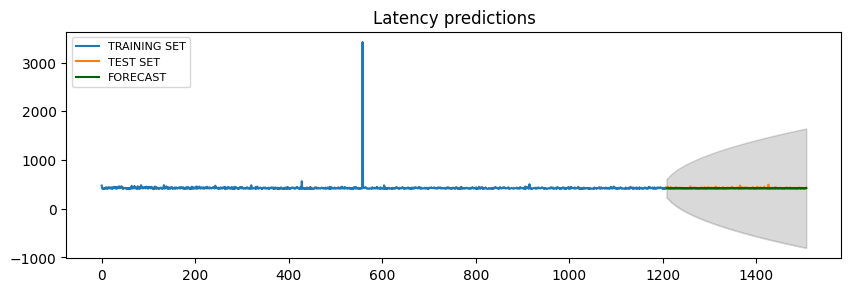

La media della latenza predetta nel frame è: 421.48416088417775
La media della latenza effettiva nel frame è: 422.9801000000001
MAPE: 2.1922275927054087%
MODELLO N°:4 F:3 sufficientemente accurato


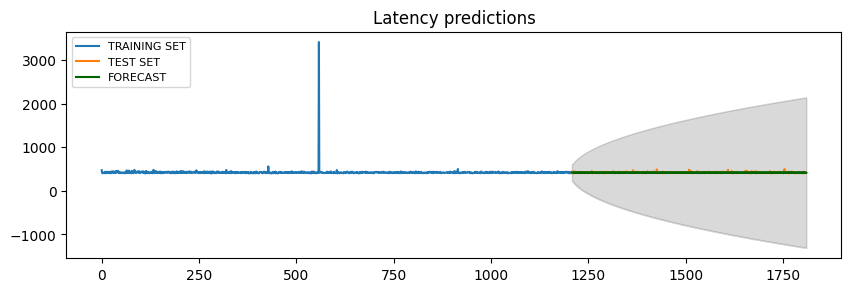

La media della latenza predetta nel frame è: 421.47918736277256
La media della latenza effettiva nel frame è: 422.9423383084579
MAPE: 2.310363892669045%
MODELLO N°:5 F:3 non sufficientemente accurato
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[2] intercept   : AIC=inf, Time=1.52 sec
 ARIMA(0,0,0)(0,1,0)[2] intercept   : AIC=18450.697, Time=0.06 sec
 ARIMA(1,0,0)(1,1,0)[2] intercept   : AIC=18028.472, Time=0.55 sec
 ARIMA(0,0,1)(0,1,1)[2] intercept   : AIC=inf, Time=0.99 sec
 ARIMA(0,0,0)(0,1,0)[2]             : AIC=18448.697, Time=0.06 sec
 ARIMA(1,0,0)(0,1,0)[2] intercept   : AIC=18452.696, Time=0.11 sec
 ARIMA(1,0,0)(2,1,0)[2] intercept   : AIC=17850.744, Time=0.85 sec
 ARIMA(1,0,0)(2,1,1)[2] intercept   : AIC=inf, Time=1.78 sec
 ARIMA(1,0,0)(1,1,1)[2] intercept   : AIC=inf, Time=1.14 sec
 ARIMA(0,0,0)(2,1,0)[2] intercept   : AIC=17848.749, Time=0.63 sec
 ARIMA(0,0,0)(1,1,0)[2] intercept   : AIC=18026.477, Time=0.36 sec
 ARIMA(0,0,0)(2,1,1)[2] intercept   : AIC=in

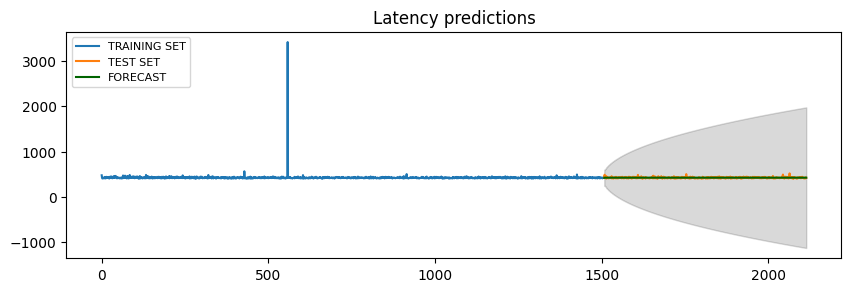

La media della latenza predetta nel frame è: 423.5844942364675
La media della latenza effettiva nel frame è: 422.80088962108726
MAPE: 2.346418515808222%
MODELLO N°:6 F:3 non sufficientemente accurato
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[2] intercept   : AIC=inf, Time=1.99 sec
 ARIMA(0,0,0)(0,1,0)[2] intercept   : AIC=21840.699, Time=0.07 sec
 ARIMA(1,0,0)(1,1,0)[2] intercept   : AIC=21333.028, Time=0.61 sec
 ARIMA(0,0,1)(0,1,1)[2] intercept   : AIC=inf, Time=1.26 sec
 ARIMA(0,0,0)(0,1,0)[2]             : AIC=21838.699, Time=0.05 sec
 ARIMA(1,0,0)(0,1,0)[2] intercept   : AIC=21842.699, Time=0.11 sec
 ARIMA(1,0,0)(2,1,0)[2] intercept   : AIC=21119.439, Time=1.01 sec
 ARIMA(1,0,0)(2,1,1)[2] intercept   : AIC=inf, Time=1.88 sec
 ARIMA(1,0,0)(1,1,1)[2] intercept   : AIC=inf, Time=1.45 sec
 ARIMA(0,0,0)(2,1,0)[2] intercept   : AIC=21117.442, Time=0.68 sec
 ARIMA(0,0,0)(1,1,0)[2] intercept   : AIC=21331.032, Time=0.42 sec
 ARIMA(0,0,0)(2,1,1)[2] intercept   : AIC=in

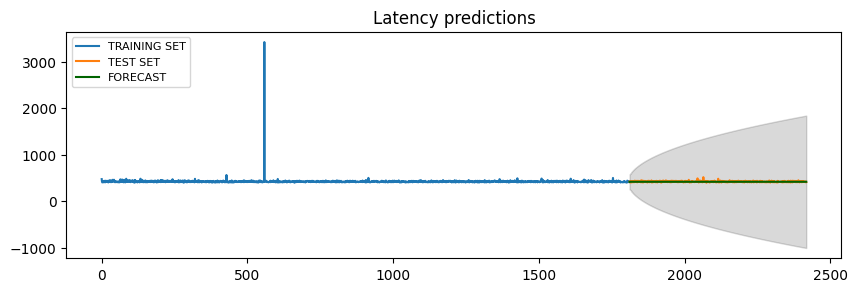

La media della latenza predetta nel frame è: 418.90662007926875
La media della latenza effettiva nel frame è: 421.89775947281754
MAPE: 2.080348553855791%
MODELLO N°:7 F:3 sufficientemente accurato


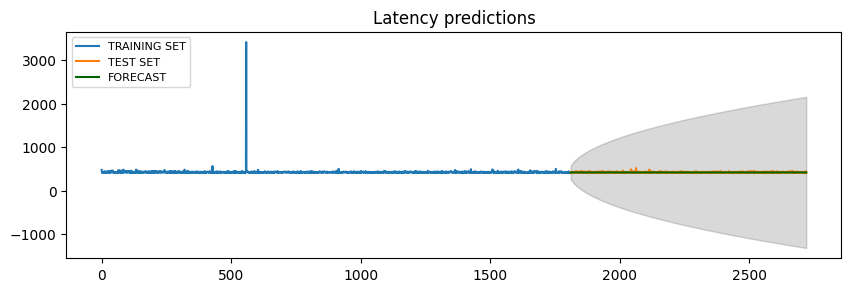

La media della latenza predetta nel frame è: 418.90657637656557
La media della latenza effettiva nel frame è: 422.1001317233809
MAPE: 2.1236713534404736%
MODELLO N°:8 F:3 sufficientemente accurato


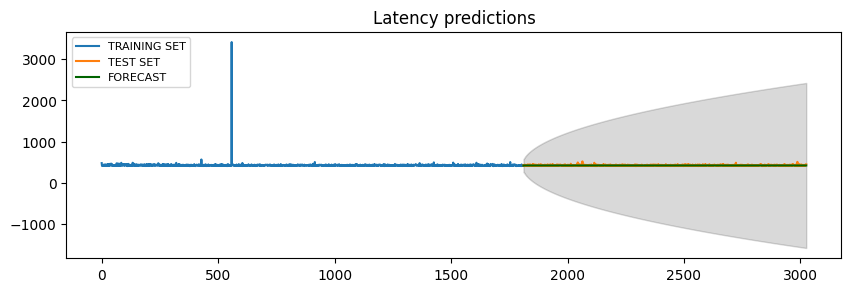

La media della latenza predetta nel frame è: 418.90655454319847
La media della latenza effettiva nel frame è: 422.1358106995883
MAPE: 2.127701427566552%
MODELLO N°:9 F:3 sufficientemente accurato


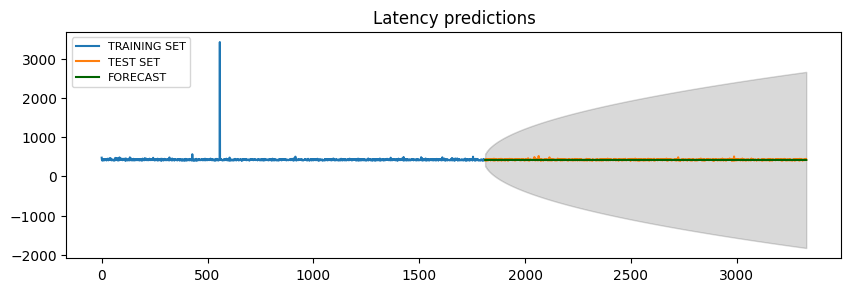

La media della latenza predetta nel frame è: 418.9064945477395
La media della latenza effettiva nel frame è: 421.90490777338596
MAPE: 2.0913844689998866%
MODELLO N°:10 F:3 sufficientemente accurato


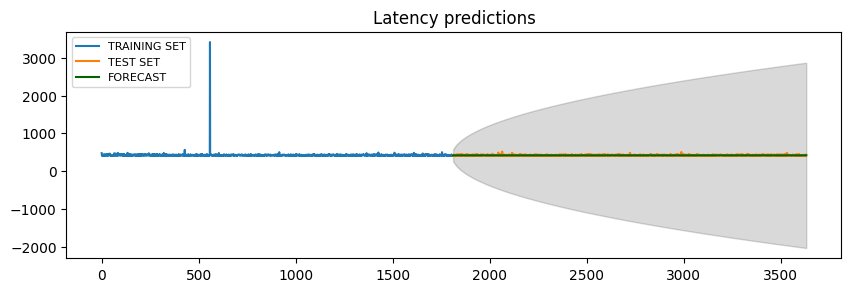

La media della latenza predetta nel frame è: 418.9065327697013
La media della latenza effettiva nel frame è: 421.9703844041738
MAPE: 2.1014883901564323%
MODELLO N°:11 F:3 sufficientemente accurato


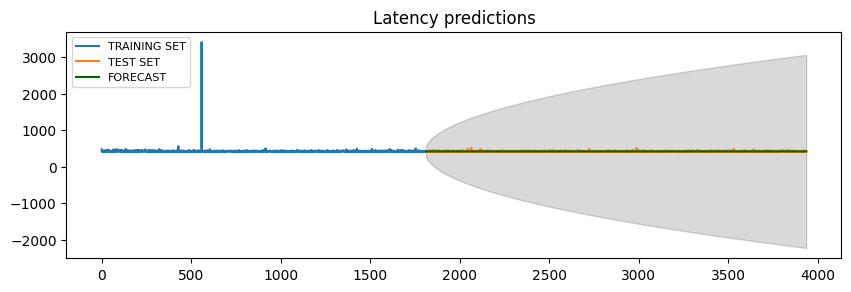

La media della latenza predetta nel frame è: 418.90652652449927
La media della latenza effettiva nel frame è: 421.90933176470594
MAPE: 2.0986708130510077%
ADDESTRAMENTO FASCIA 3 TERMINATO


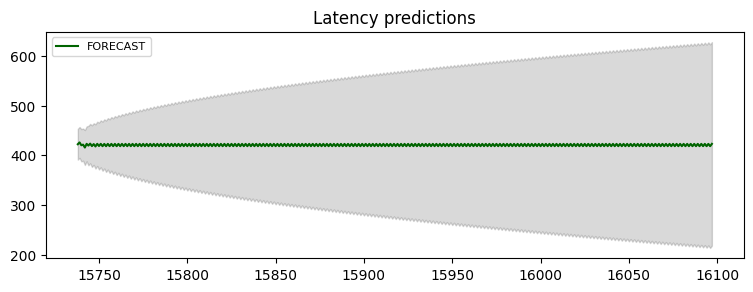

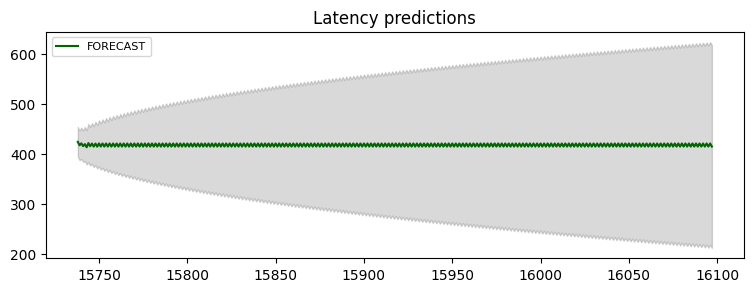

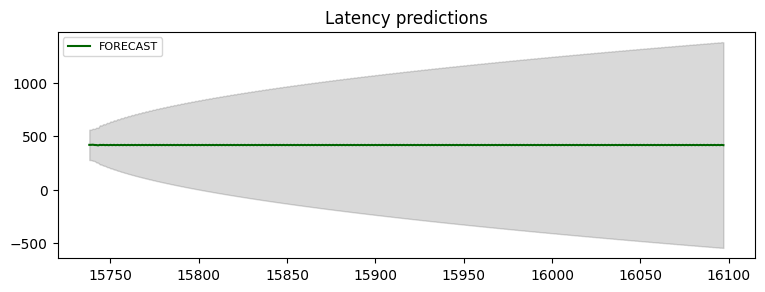

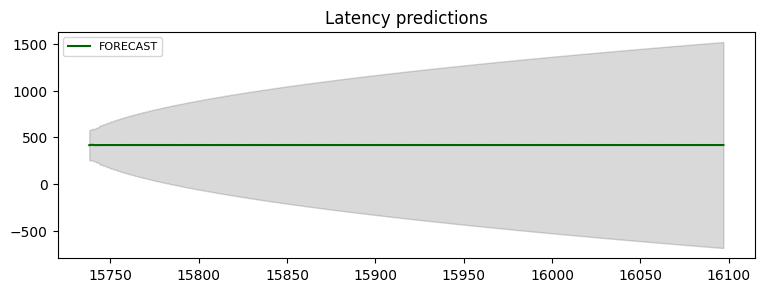

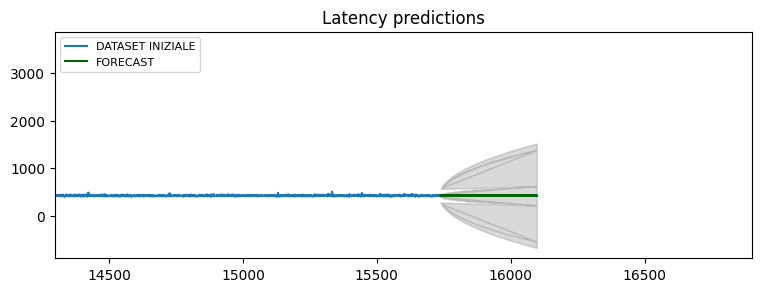

La media della latenza predetta per la prossima fascia oraria [0-5] è di: 420.68160831677284
La media della latenza predetta per la prossima fascia oraria [6-11] è di: 417.7579412633499
La media della latenza predetta per la prossima fascia oraria [12-17] è di: 418.2748487274435
La media della latenza predetta per la prossima fascia oraria [18-23] è di: 418.9065120233068
La media della latenza predetta per le 24 ore successive al 2016-06-14 23:59:48 è di: 418.9052275827179


In [ ]:
df = read()
df, DFDays,DFHours = preprocessing(df)

models = modello_iterativo_hour(DFHours,DFDays)
prevision = prev_next_day_s(df,DFDays,DFHours,models)
